In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_ml as pdml
import pyodbc

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, IsolationForest, BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, average_precision_score, recall_score 
from sklearn.metrics import auc, precision_score, confusion_matrix, f1_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

[QGrid](https://github.com/quantopian/qgrid)

In [2]:
cnxn = pyodbc.connect(DSN='BGI40PROD')

cursor = cnxn.cursor()

In [3]:
sql = """select	CONSTITUENTSYSTEMID
        ,CONSTITUENTLOOKUPID
		,SORTNAMESHORT
		,CONSTITUENTAGE
from uif.v_DIM_CONSTITUENT
where ISINDIVIDUAL = 1 and ISDECEASED = 0 and ISACTIVE = 1"""

In [4]:
app = pd.read_sql(sql, con=cnxn)

In [5]:
app.head()

,CONSTITUENTSYSTEMID,CONSTITUENTLOOKUPID,SORTNAMESHORT,CONSTITUENTAGE
0,C2965E11-C008-4FF2-B017-209BEFD4C783,0343858,"Heimer, David",63
1,273ECF10-CA71-4C80-8111-209D7DA58A3A,0294513,"Miers, Shirley",71
2,9A9DC251-C788-4F3E-AEDE-209DDAFA8526,0727383,"Hodson, Megan",28
3,EA62AA86-4FE8-456D-86E4-209DFF035330,1183764,"McMillan, John",0
4,63B47CDA-AC8D-4B0B-942D-209E34BA6F71,0278068,"Thomas, Loretta",83


In [ ]:
# pandas_ml confusion matrix: http://pandas-ml.readthedocs.io/en/latest/conf_mat.html

In [5]:
df = pd.read_csv("//uiffs01/dataanalytics/LawAffinityPG/lawdata_new1.csv")

df.fillna(0, inplace=True)  # we should do a better job of cleaning than this...

In [11]:
list(df)

['CONSTITUENTSYSTEMID',
 'HAS_PLANNED_GIFT',
 'LWG_DONOR',
 'LAW_GRAD',
 'LAW_GRAD_LWG_DONOR',
 'GRANDPARENT_LAW_GRAD',
 'PARENT_LAW_GRAD',
 'LEGACY_GRAD',
 'AFFIN_BOARD_MEMBERSHIP',
 'AFFIN_EMPLOYEE',
 'AFFIN_EMPLOYEE_RELATIONSHIP',
 'AFFIN_EVENT_REGISTRANT',
 'AFFIN_FAMILY_RELATIONSHIP',
 'AFFIN_GRATEFUL_PATIENT',
 'HAS_EMAIL',
 'AFFIN_IMMEDIATE_FAMILY',
 'MULTIPLE_DEGREE',
 'SCHOLARSHIP_RECIPIENT',
 'AFFIN_STUDENT_ENGAGEMENT',
 'AFFIN_UI_UIF_VOLUNTEER',
 'AFFIN_UI_RETIREE',
 'LAW_VOLUNTEER',
 'LAW_STUDENT_INVOLVEMENT',
 'LAW_SOLICITATION_RESPONDENT',
 'LWG_GIFTYEARSCOUNT_BEFORE_PG',
 'CLASS_GIFT_DONOR',
 'RESIDENCE_COUNT_EVER',
 'IOWA_RESIDENCE_EVER',
 'NON_IOWA_RESIDENCE_EVER',
 'NON_IA_MIDWEST_RESIDENCE_EVER',
 'SNOWBIRD_RESIDENCE_EVER',
 'ISDECEASED',
 'SPOUSEDECEASED',
 'HIGH_TITLE',
 'STOCK_GIFT',
 'STOCKHOLDER',
 'PATRON',
 'AMLAW_EVER',
 'SPOUSE_GRAD',
 'SPOUSE_LAW_GRAD',
 'LWG_CONSECUTIVE_PRIOR_PG',
 'NON_LWG_CONSECUTIVE_PRIOR_PG',
 'NON_LWG_GIFTYEARSCOUNT_PRIOR_PG',
 'LWG_S

In [6]:
# helper function to create column of bin values from LWG_SUM_BEFORE_PG
# https://community.modeanalytics.com/python/tutorial/defining-python-functions/
def amount_bin (value):
    if value == 0 :
        return 'nonDonor'
    elif 0 < value < 100 :
        return 'donor_<100'
    elif 100 <= value < 250 :
        return 'donor_100-249'
    elif 250 <= value < 500 :
        return 'donor_250-499'
    elif 500 <= value < 1000 :
        return 'donor_500-999'
    elif 1000 <= value < 5000 :
        return 'donor_1000-4999'
    elif 5000 <= value < 10000 :
        return 'donor_5000-9999'
    elif 10000 <= value < 25000 :
        return 'donor_10000-24999'
    elif 25000 <= value < 50000 :
        return 'donor_25000-49999'
    return 'donor_>50000'

In [7]:
df['LWG_SUM_PRIOR_PG_BIN'] = df['LWG_SUM_BEFORE_PG'].apply(amount_bin)

In [ ]:
df[['CONSTITUENTSYSTEMID','LWG_SUM_BEFORE_PG','LWG_SUM_PRIOR_PG_BIN']].head(100)

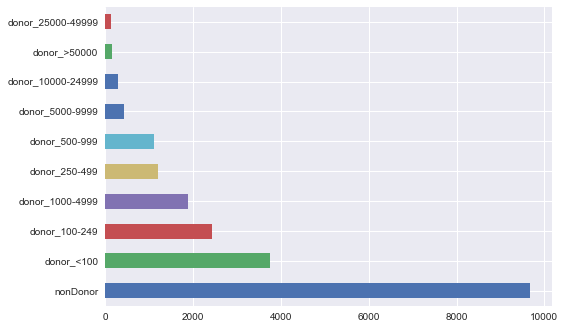

In [9]:
df['LWG_SUM_PRIOR_PG_BIN'].value_counts().plot(kind='barh')

In [10]:
list(df) # for the list of columns, or features, for selection in 'cols'

['CONSTITUENTSYSTEMID',
 'HAS_PLANNED_GIFT',
 'LWG_DONOR',
 'LAW_GRAD',
 'LAW_GRAD_LWG_DONOR',
 'GRANDPARENT_LAW_GRAD',
 'PARENT_LAW_GRAD',
 'LEGACY_GRAD',
 'AFFIN_BOARD_MEMBERSHIP',
 'AFFIN_EMPLOYEE',
 'AFFIN_EMPLOYEE_RELATIONSHIP',
 'AFFIN_EVENT_REGISTRANT',
 'AFFIN_FAMILY_RELATIONSHIP',
 'AFFIN_GRATEFUL_PATIENT',
 'HAS_EMAIL',
 'AFFIN_IMMEDIATE_FAMILY',
 'MULTIPLE_DEGREE',
 'SCHOLARSHIP_RECIPIENT',
 'AFFIN_STUDENT_ENGAGEMENT',
 'AFFIN_UI_UIF_VOLUNTEER',
 'AFFIN_UI_RETIREE',
 'LAW_VOLUNTEER',
 'LAW_STUDENT_INVOLVEMENT',
 'LAW_SOLICITATION_RESPONDENT',
 'LWG_GIFTYEARSCOUNT_BEFORE_PG',
 'CLASS_GIFT_DONOR',
 'RESIDENCE_COUNT_EVER',
 'IOWA_RESIDENCE_EVER',
 'NON_IOWA_RESIDENCE_EVER',
 'NON_IA_MIDWEST_RESIDENCE_EVER',
 'SNOWBIRD_RESIDENCE_EVER',
 'ISDECEASED',
 'SPOUSEDECEASED',
 'HIGH_TITLE',
 'STOCK_GIFT',
 'STOCKHOLDER',
 'PATRON',
 'AMLAW_EVER',
 'SPOUSE_GRAD',
 'SPOUSE_LAW_GRAD',
 'LWG_CONSECUTIVE_PRIOR_PG',
 'NON_LWG_CONSECUTIVE_PRIOR_PG',
 'NON_LWG_GIFTYEARSCOUNT_PRIOR_PG',
 'LWG_S

In [ ]:
cols = df.columns.tolist() # another (faster?) method for generating feature list

[Dropping select columns from a dataframe](https://stackoverflow.com/a/37717675/8104811)

In [ ]:
cols1 = df.drop(['CONSTITUENTSYSTEMID', 'HAS_PLANNED_GIFT', 'HAS_EMAIL', 'ISDECEASED'], axis = 1)

In [ ]:
cols1.columns.tolist()

[12 useful pandas techniques](https://www.analyticsvidhya.com/blog/2016/01/12-pandas-techniques-python-data-manipulation/)

In [ ]:
cols1.head()

In [ ]:
scaler = StandardScaler()

X = cols1
y = df.HAS_PLANNED_GIFT

X.loc[:, ['LWG_GIFTYEARSCOUNT_BEFORE_PG',
          'RESIDENCE_COUNT_EVER',
          'LWG_CONSECUTIVE_PRIOR_PG',
          'NON_LWG_CONSECUTIVE_PRIOR_PG',
          'NON_LWG_GIFTYEARSCOUNT_PRIOR_PG',
          'LWG_SUM_BEFORE_PG',
          'NON_LWG_SUM_BEFORE_PG',
          'PRE_PG_YEARS_WITH_CONTACT_REPORT',
          'INVOLVEMENT_COUNT',
          'INVOLVEMENT_TYPE_COUNT']] = \
scaler.fit_transform(X.loc[:, ['LWG_GIFTYEARSCOUNT_BEFORE_PG',
          'RESIDENCE_COUNT_EVER',
          'LWG_CONSECUTIVE_PRIOR_PG',
          'NON_LWG_CONSECUTIVE_PRIOR_PG',
          'NON_LWG_GIFTYEARSCOUNT_PRIOR_PG',
          'LWG_SUM_BEFORE_PG',
          'NON_LWG_SUM_BEFORE_PG',
          'PRE_PG_YEARS_WITH_CONTACT_REPORT',
          'INVOLVEMENT_COUNT',
          'INVOLVEMENT_TYPE_COUNT']])


X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.33, random_state=42)

In [ ]:
X.LWG_SUM_BEFORE_PG.head()

[Tuning Random Forest Models](https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/)

In [ ]:
print("X_train:", X_train.shape)

clf = RandomForestClassifier(n_estimators=50, bootstrap=True, n_jobs=-1, random_state=11251442, class_weight="balanced_subsample")
clf = clf.fit(X_train, y_train) 

selector = SelectFromModel(clf, threshold=".5*mean", prefit=True)
X_train2 = selector.transform(X_train)
X_test2 = selector.transform(X_test)
print("X_train2:", X_train2.shape)
print("X_test2:", X_test2.shape)

In [ ]:
def col_index(df):
    return {i: list(df.columns)[i] for i in range(len(df.columns))}

ind = col_index(X)

In [ ]:
n = X_train2.shape[1]

features = list(ind.values())
importances = clf.feature_importances_
indices = list(np.argsort(importances))[-n:]

plt.figure(figsize=(8,26))
plt.title('Feature Importances')
plt.barh(range(len(indices)), [importances[i] for i in indices], color='#FFCD00', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices]) 
plt.xlabel('Relative Importance');

In [ ]:
top = [ind[i] for i in indices[-n:]]

top.reverse()

top

In [ ]:
# modify the model params/values here for testing

rf = RandomForestClassifier(oob_score = True, n_jobs = -1,random_state =11251442, max_features = "auto", class_weight="balanced_subsample")

param_grid = {"n_estimators": [1000, 1500, 2000],
              "max_depth": [None]
             }

gs = GridSearchCV(rf, param_grid=param_grid, scoring = 'average_precision', n_jobs=-1)

model = gs.fit(X_train2, y_train)

In [ ]:
model.cv_results_

In [ ]:
final_rf = model.best_estimator_

In [ ]:
final_rf = model.best_estimator_

final_rf.predict_proba(X_test2)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train, final_rf.predict_proba(X_train2)[:, 1])
roc_auc = auc(fpr, tpr)

Fpr, Tpr, Thresholds = roc_curve(y_test, final_rf.predict_proba(X_test2)[:, 1])
Roc_auc = auc(Fpr, Tpr)

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Train ROC (area = %0.2f)' % roc_auc)
plt.plot(fpr, thresholds, color='darkorange', linestyle='-.')
plt.plot(Fpr, Tpr, color='gray',
         lw=lw, label='Test ROC (area = %0.2f)' % Roc_auc)
plt.plot(Fpr, Thresholds, color='gray', linestyle='-.', lw=3)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('roc.png')
plt.show();


In [ ]:
n = X_train2.shape[1]

features = list(ind.values())
importances = clf.feature_importances_
indices = list(np.argsort(importances))[-n:]

plt.figure(figsize=(8,26))
plt.title('Feature Importances')
plt.barh(range(len(indices)), [importances[i] for i in indices], color='#FFCD00', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices]) 
plt.xlabel('Relative Importance');

In [ ]:
plt.scatter(final_rf.predict_proba(X_test2)[:, 1], y_test)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train, final_rf.predict_proba(X_train2)[:, 1])
roc_auc = auc(fpr, tpr)

Fpr, Tpr, Thresholds = roc_curve(y_test, final_rf.predict_proba(X_test2)[:, 1])
Roc_auc = auc(Fpr, Tpr)

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Train ROC (area = %0.2f)' % roc_auc)
plt.plot(fpr, thresholds, color='darkorange', linestyle='-.')
plt.plot(Fpr, Tpr, color='gray',
         lw=lw, label='Test ROC (area = %0.2f)' % Roc_auc)
plt.plot(Fpr, Thresholds, color='gray', linestyle='-.', lw=3)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('roc.png')
plt.show();


In [ ]:
nope = X[y == 0]

X2 = selector.transform(nope)

#col = ['ConstituentID', 'ConstituentAge', "SCORE"] +  cols

nope = nope.assign(SCORE = (final_rf.predict_proba(X2)[:,1]))

#nope.loc[:, col].sort_values(by="SCORE", ascending=False).head(50)

nope.sort_values(by="SCORE", ascending=False).head()

In [ ]:
#set series to_frame to enable merge

nope = pd.merge(nope, df.loc[df.ISDECEASED==0,"CONSTITUENTSYSTEMID"].to_frame(), how="inner", left_index=True, right_index=True )
nope.head(50)

In [ ]:
nope.sort_values(by="SCORE", ascending=False).head(100).to_clipboard()

In [ ]:
nope.loc[:, ['LWG_GIFTYEARSCOUNT_BEFORE_PG',
          'RESIDENCE_COUNT_EVER',
          'LWG_CONSECUTIVE_PRIOR_PG',
          'NON_LWG_CONSECUTIVE_PRIOR_PG',
          'NON_LWG_GIFTYEARSCOUNT_PRIOR_PG',
          'LWG_SUM_BEFORE_PG',
          'NON_LWG_SUM_BEFORE_PG',
          'PRE_PG_YEARS_WITH_CONTACT_REPORT',
          'INVOLVEMENT_COUNT',
          'INVOLVEMENT_TYPE_COUNT']] = \
scaler.inverse_transform(nope.loc[:, ['LWG_GIFTYEARSCOUNT_BEFORE_PG',
          'RESIDENCE_COUNT_EVER',
          'LWG_CONSECUTIVE_PRIOR_PG',
          'NON_LWG_CONSECUTIVE_PRIOR_PG',
          'NON_LWG_GIFTYEARSCOUNT_PRIOR_PG',
          'LWG_SUM_BEFORE_PG',
          'NON_LWG_SUM_BEFORE_PG',
          'PRE_PG_YEARS_WITH_CONTACT_REPORT',
          'INVOLVEMENT_COUNT',
          'INVOLVEMENT_TYPE_COUNT']])

In [ ]:
nope = pd.merge(nope, app, how='inner', on='CONSTITUENTSYSTEMID')

In [ ]:
nope.sort_values(by="SCORE", ascending=False).head(100).to_clipboard()

In [ ]:
nope.head()

In [ ]:
y_test.describe()

In [ ]:
nope.head()

In [ ]:
y_test.head()

In [ ]:
clf.predict?


In [ ]:
y_train.describe()

In [ ]:
nope.head()

In [ ]:
# create objects to use to create a confusion matrix
# y_test = y_true y_pred = clf.predict_proba(X_test)

In [ ]:
pred = clf.predict_proba(X_test)


In [ ]:
pred

In [ ]:
# create a function to indicate whether column 1 in pred is > .5

In [ ]:
def threshold (predict):
    if predict >= .5 :
        return 1 
    else:
        return 0

In [ ]:
d = []

for i in range(pred.shape[0]):
    if pred[i, 1] >= .5:
        d.append((i, 0, pred[i, 1]))
    else:
        d.append((i,0,pred[i, 1]))
d[:10]       

In [ ]:
np.vectorize?

In [ ]:
np.apply_along_axis(threshold, 1, pred[:,1].reshape(-1,1))

In [ ]:
pred[:, 1].shape

In [ ]:
pred[:, 1].reshape

In [ ]:
pred[:, 1].reshape

In [ ]:
thresh = np.vectorize(threshold)

In [ ]:
thresh(pred[:, 1]).sum()

In [ ]:
confusion_matrix(y_test,thresh(pred[:, 1]))